In [26]:
%pip install catboost matplotlib pandas scikit-learn kaggle optuna ipywidgets kaleido shap jupyterlab-rise plotly

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:

import os
from pathlib import Path
container_check = os.getenv("iscontainer")
if container_check=="y":
    config_dir = Path("c:/Users/treal/.kaggle")
    config_dir.mkdir(parents=True, exist_ok=True)
    
    with open(config_dir / "kaggle.json", "w") as dst:
        with open("./kaggle.json", "r") as src:
            dst.write(src.read())


In [28]:
import os
import zipfile
from pathlib import Path
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# dataset = "student-habits-vs-academic-performance"
# dataset_test = "jayaantanaath/student-habits-vs-academic-performance"
# download_folder = Path("data/student-habits-vs-academic-performance")
# zip_path = download_folder / "student-habits-vs-academic-performance.zip"
# download_folder.mkdir(parents=True, exist_ok=True)

# api.competition_download_files(dataset, path=str(download_folder))
# api.dataset_download_files(dataset_test, path=str(download_folder), unzip=True)

dataset_name = "jayaantanaath/student-habits-vs-academic-performance" #tutaj wpisuje baze
download_folder = Path("data/student-habits-vs-academic-performance") #tutaj bedzie folder w ktorym bedzie dane
download_folder.mkdir(parents=True, exist_ok=True)

api.dataset_download_files(dataset_name, path=str(download_folder), unzip=True)


# with zipfile.ZipFile(zip_path, "r") as zip_ref:
#     zip_ref.extractall(str(download_folder))
# os.remove(zip_path)

Dataset URL: https://www.kaggle.com/datasets/jayaantanaath/student-habits-vs-academic-performance


Let's take a look at the data folder:

In [29]:
!dir "./data/student-habits-vs-academic-performance"

 Volume in drive C has no label.
 Volume Serial Number is 67A3-0D30

 Directory of c:\Users\treal\Desktop\Zaliczenie_MLOPS\notebooks\data\student-habits-vs-academic-performance

26.07.2025  21:45    <DIR>          .
26.07.2025  21:42    <DIR>          ..
26.07.2025  21:45            73�663 student_habits_performance.csv
               1 File(s)         73�663 bytes
               2 Dir(s)  42�313�740�288 bytes free


Perfect, so the data is in place and we can take a look at it, putting aside the PassengerId column since that is not going to be trained on.

In [30]:
import pandas as pd

df_train = pd.read_csv(download_folder / "student_habits_performance.csv")
df_ids = df_train.pop("student_id")  # set aside student_id

df_train.sample(10)

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
750,24,Female,6.1,1.9,0.2,No,97.6,5.9,Poor,6,Bachelor,Poor,6,No,98.5
171,21,Female,5.3,2.4,0.1,No,85.5,5.5,Good,0,Bachelor,Good,3,Yes,85.8
621,18,Female,3.4,1.7,1.4,No,95.5,7.8,Good,0,Master,Good,2,No,70.7
33,18,Female,4.0,0.9,1.1,No,99.5,5.8,Poor,2,NaN,Average,5,No,70.7
12,19,Female,3.7,2.1,0.4,Yes,81.1,4.5,Fair,1,Bachelor,Good,9,No,76.9
844,21,Female,0.7,3.2,0.3,Yes,72.7,7.9,Fair,2,High School,Good,7,Yes,47.2
786,23,Male,4.1,2.6,2.4,No,77.3,6.9,Good,2,Bachelor,Average,9,No,85.3
420,18,Female,3.8,2.9,4.1,Yes,68.7,9.1,Fair,4,Master,Good,3,No,70.8
37,17,Male,4.3,2.5,0.0,Yes,64.1,3.9,Good,0,High School,Average,2,No,59.4
520,24,Female,4.1,3.3,0.6,Yes,78.7,5.1,Good,2,Bachelor,Good,1,No,62.7


## Data overview
Okay we have been given the following data dictionary: 

Target is **"Survived"**, whether the passenger survived the sinking.  
* **PClass**: Passenger Ticket Class, either 1, 2, 3 for 1st, 2nd, 3rd class. Categorical.
* **Name**: Name of the passenger. Not usable raw.
* **Sex**: Sex of the passenger. Categorical.
* **Age**: Age of the passenger, fractional if less than 1, if estimated then in the form of xx.5. Numerical, candidate for binning into age groups.
* **SibSp**: Number of siblings/spouses aboard. Numerical.
* **parch**: Number of parents/children aboard. Numerical.
* **ticket**: Ticket number. Not usable raw. Unclear if usable at all.  
* **fare**: How much paid for the ticket. Numerical.
* **cabin**: Cabin number. Not usable raw. 
* **embarked**: Port of embarkation, either C = Cherbourg, Q = Queenstown, S = Southampton. Categorical.  

And the data looks like this when it comes to missing data:

In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            1000 non-null   int64  
 1   gender                         1000 non-null   object 
 2   study_hours_per_day            1000 non-null   float64
 3   social_media_hours             1000 non-null   float64
 4   netflix_hours                  1000 non-null   float64
 5   part_time_job                  1000 non-null   object 
 6   attendance_percentage          1000 non-null   float64
 7   sleep_hours                    1000 non-null   float64
 8   diet_quality                   1000 non-null   object 
 9   exercise_frequency             1000 non-null   int64  
 10  parental_education_level       909 non-null    object 
 11  internet_quality               1000 non-null   object 
 12  mental_health_rating           1000 non-null   in

The cabin column is mostly null so we will drop the column.  
Also we are not sure how to use the name since it is a string type with many, presumably all unique values, so can't just consider it a categorical value, so let's also drop that one for now.  
Finally the ticket serial number is not usable either. 

In [32]:
df_train = df_train.drop(columns=["parental_education_level"])
df_train.head()

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Average,8,Yes,56.2
1,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,Average,8,No,100.0
2,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,Poor,1,No,34.3
3,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Good,1,Yes,26.8
4,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Good,1,No,66.4


In [33]:
df_train['pass'] = (df_train['exam_score']>70).astype(int)

In [34]:
df_train.head()

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,internet_quality,mental_health_rating,extracurricular_participation,exam_score,pass
0,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Average,8,Yes,56.2,0
1,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,Average,8,No,100.0,1
2,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,Poor,1,No,34.3,0
3,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Good,1,Yes,26.8,0
4,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Good,1,No,66.4,0


In [35]:
categorical = [
    "gender", 
    "part_time_job", 
    "diet_quality" ,
    "internet_quality" ,
    "extracurricular_participation" ,
]

y_train = df_train.pop("pass")
X_train = df_train

categorical_indices = [X_train.columns.get_loc(col) for col in categorical if col in X_train.columns]
categorical_indices

[1, 5, 8, 10, 12]

And verifying that there are now no nulls

In [36]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            1000 non-null   int64  
 1   gender                         1000 non-null   object 
 2   study_hours_per_day            1000 non-null   float64
 3   social_media_hours             1000 non-null   float64
 4   netflix_hours                  1000 non-null   float64
 5   part_time_job                  1000 non-null   object 
 6   attendance_percentage          1000 non-null   float64
 7   sleep_hours                    1000 non-null   float64
 8   diet_quality                   1000 non-null   object 
 9   exercise_frequency             1000 non-null   int64  
 10  internet_quality               1000 non-null   object 
 11  mental_health_rating           1000 non-null   int64  
 12  extracurricular_participation  1000 non-null   ob

Okay now we need to choose the best parameters for training the model.  
Using optuna to easily set up a study, with typical ranges for the parameters.  
Then run the study and save the best parameters.  
Also putting in an if-else to check for existing file to not run again unnecessarily.

In [38]:
import joblib
import optuna
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv

outfolder = Path("..\\results")
outfolder.mkdir(parents=True, exist_ok=True)

best_params_path = outfolder / "best_params.pkl"

if not best_params_path.is_file():
    X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    
    def objective(trial):
        params = {
            "depth": trial.suggest_int("depth", 2, 10),
            "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3),
            "iterations": trial.suggest_int("iterations", 100, 300),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 100.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.01, 1),
            "random_strength": trial.suggest_float("random_strength", 1e-5, 100.0, log=True)
        }
        model = CatBoostClassifier(**params, verbose=0)
        model.fit(X_train_opt, y_train_opt, eval_set=(X_val_opt, y_val_opt), cat_features=categorical_indices, early_stopping_rounds=50)
        return model.get_best_score()["validation"]["Logloss"]
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)
    
    joblib.dump(study.best_params, best_params_path)
    params = study.best_params
else:
    params = joblib.load(best_params_path)
print("Best Parameters:", params)

Best Parameters: {'depth': 9, 'learning_rate': 0.1989710549297809, 'iterations': 225, 'l2_leaf_reg': 5.203681083589466, 'bagging_temperature': 0.6748870052060675, 'random_strength': 0.27921747675539976}


Okay now we have the optimal hyperparameters for training our model.  
Let's train the model using cross validation to get a better idea of the performance.  
Given the lack of data we are not setting aside a test set.  
Setting metric to F1 to optimize both Precision and Recall and save results to file.  

In [40]:
params["eval_metric"] = "F1"
params["loss_function"] = "Logloss"

model = CatBoostClassifier(
    **params,
    verbose=True
)

data = Pool(X_train, y_train, cat_features=categorical_indices)

cv_results = cv(
    params=params,
    pool=data,
    fold_count=5,
    partition_random_seed=42,
    shuffle=True,
)
os.makedirs(outfolder, exist_ok=True)
cv_results.to_csv(outfolder / "cv_results_zaliczeniowe.csv", index=False)

Training on fold [0/5]
0:	learn: 0.9863354	test: 0.9644670	best: 0.9644670 (0)	total: 17.9ms	remaining: 4.02s
1:	learn: 0.9938348	test: 0.9950739	best: 0.9950739 (1)	total: 36.5ms	remaining: 4.07s
2:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (2)	total: 51.4ms	remaining: 3.81s
3:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (2)	total: 74.8ms	remaining: 4.13s
4:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (2)	total: 105ms	remaining: 4.61s
5:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (2)	total: 132ms	remaining: 4.83s
6:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (2)	total: 163ms	remaining: 5.06s
7:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (2)	total: 193ms	remaining: 5.23s
8:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (2)	total: 222ms	remaining: 5.33s
9:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (2)	total: 252ms	remaining: 5.41s
10:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (2)	total: 280ms	remaining: 5.45s
11:	learn: 1.0000000	test:

Let's plot test performance during training.

In [42]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add mean performance line
fig.add_trace(
    go.Scatter(
        x=cv_results["iterations"], y=cv_results["test-F1-mean"], mode="lines", name="Mean F1 Score", line=dict(color="blue")
    )
)

# Add shaded error region
fig.add_trace(
    go.Scatter(
        x=pd.concat([cv_results["iterations"], cv_results["iterations"][::-1]]),
        y=pd.concat([cv_results["test-F1-mean"]+cv_results["test-F1-std"], 
                     cv_results["test-F1-mean"]-cv_results["test-F1-std"]]),
        fill="toself", 
        fillcolor="rgba(0, 0, 255, 0.2)",
        line=dict(color="rgba(255, 255, 255, 0)"),
        showlegend=False
    )
)

# Customize layout
fig.update_layout(
    title="Cross-Validation (N=5) Mean F1 score with Error Bands",
    xaxis_title="Training Steps",
    yaxis_title="Performance Score",
    template="plotly_white",
    yaxis=dict(range=[0.5, 1])
)

#fig.show()

fig.write_image(outfolder / "test_f1_zaliczeniowe.png")

In [43]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add mean performance line
fig.add_trace(
    go.Scatter(
        x=cv_results["iterations"], y=cv_results["test-Logloss-mean"], mode="lines", name="Mean logloss", line=dict(color="blue")
    )
)

# Add shaded error region
fig.add_trace(
    go.Scatter(
        x=pd.concat([cv_results["iterations"], cv_results["iterations"][::-1]]),
        y=pd.concat([cv_results["test-Logloss-mean"]+cv_results["test-Logloss-std"], 
                     cv_results["test-Logloss-mean"]-cv_results["test-Logloss-std"]]),
        fill="toself", 
        fillcolor="rgba(0, 0, 255, 0.2)",
        line=dict(color="rgba(255, 255, 255, 0)"),
        showlegend=False
    )
)

# Customize layout
fig.update_layout(
    title="Cross-Validation (N=5) Mean Logloss with Error Bands",
    xaxis_title="Training Steps",
    yaxis_title="Logloss",
    template="plotly_white"
)

#fig.show()

fig.write_image(outfolder / "test_logloss_zaliczeniowe.png")

Okay these plots look reasonable enough, clearly we are betting than a coin-flip, so good enough for an initial model.  
Finally we can train a model on the full dataset and performance should equal the cross validation performance.

In [45]:
model.fit(
    X_train,
    y_train,
    verbose_eval=50,
    early_stopping_rounds=50,
    cat_features=categorical_indices,
    use_best_model=False,
    plot=True
)

model.save_model(outfolder / 'catboost_model_students_habits_performance_zaliczeniowe.cbm')
joblib.dump(params, outfolder / 'model_params_zaliczeniowe.pkl')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9990206	total: 28.1ms	remaining: 6.3s
50:	learn: 1.0000000	total: 1.49s	remaining: 5.08s
100:	learn: 1.0000000	total: 3.04s	remaining: 3.73s
150:	learn: 1.0000000	total: 4.58s	remaining: 2.25s
200:	learn: 1.0000000	total: 6.15s	remaining: 734ms
224:	learn: 1.0000000	total: 6.89s	remaining: 0us


['..\\results\\model_params_zaliczeniowe.pkl']

Great, that was a lot of work but now we have a trained model that is predicting better than chance saved to a model file.  
Now let's predict on the test set and create some shapley plots to convince people that our predictions make sense!

In [46]:
df_test = pd.read_csv( "c:\\Users\\treal\\desktop\\mlops_asessment_1\\notebooks\\data\\student_habits_test_25.csv")

In [47]:
df_test.head()

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,internet_quality,mental_health_rating,extracurricular_participation,exam_score,pass
0,19,Male,5.9,1.5,0.7,Yes,83.8,9.2,Poor,6,Poor,1,Yes,37.5,0
1,18,Male,5.7,4.2,2.1,No,79.5,8.7,Poor,2,Good,7,No,42.2,0
2,21,Female,0.8,2.3,1.8,No,80.2,8.6,Good,7,Good,2,No,26.3,0
3,22,Female,4.6,4.2,0.2,Yes,88.7,9.9,Poor,1,Average,5,No,70.9,0
4,23,Male,3.0,1.3,1.3,Yes,80.5,4.2,Good,3,Poor,8,No,41.6,0


In [48]:
model.predict(df_test)

array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0])

Making sure columns are in the right order, and then doing the prediction.

In [49]:
preds = model.predict(df_test)

Great now it works, but should we really be copy pasting code around?  
What if we want to change the preprocessing later?  
Anyways let's get the shapley values.

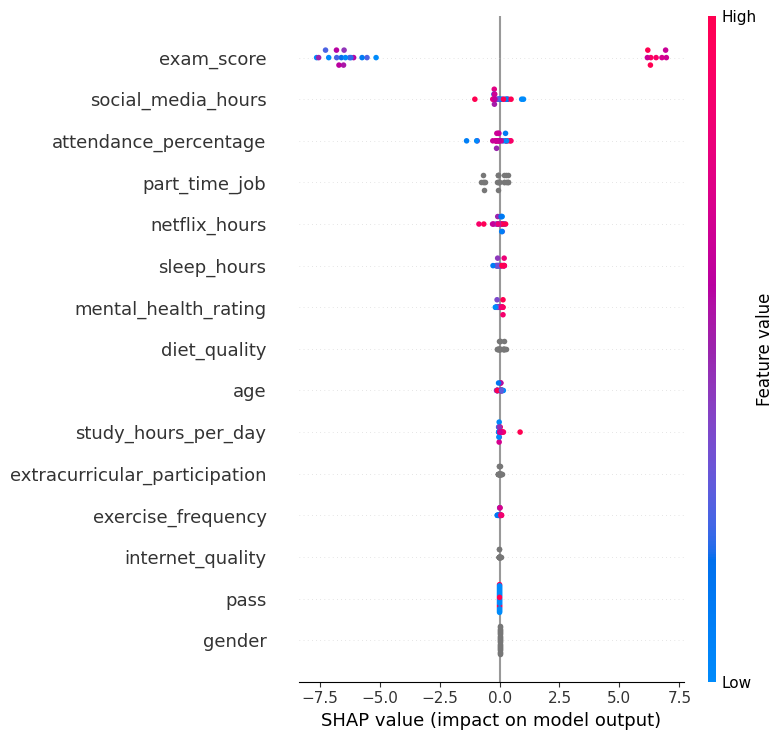

In [50]:
import shap
import matplotlib.pyplot as plt
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_test)

shap.summary_plot(shap_values, df_test, show=False)
plt.savefig(outfolder / "test_shap_overall.png")

Okay now we have something to look at to convince ourselves that the model is making sense.  
Finally let's save the predictions to a csv file as required by kaggle, so that we can get the final performance.

In [52]:
df_test["student_id"] = df_test.index
df_test["pass"] = preds
df_test[["student_id", "pass"]].to_csv(outfolder / "predictions_zaliczeniowe.csv", index=False)

All done and dusted, on to the next project right?  
Let's present to the client.

student_id,pass
0,0
1,0
2,0
3,1
4,0
5,1
6,0
7,1
8,1
9,0
10,1
11,0
12,0
13,0
14,1
15,0
16,0
17,0
18,0
19,0
20,1
21,0
22,0
23,1
24,0